In [1]:
import data_loading
import model_loading
import data_raw
import utils
from tensorflow import keras
import numpy as np
import tensorflow as tf

1.24.3
2.10.0
2.10.0


C:\Users\santi\.conda\envs\tf-directml\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Cargar datos y modelos

In [6]:
# Carga de imágenes de entrenamiento y test

train_data, train_labels, test_data, test_labels = data_loading.cargar_train_test_data()

In [10]:
modelo_base = model_loading.cargar_baseline_model()
modelo_naive = model_loading.cargar_naive_model()
modelo_destilado = model_loading.cargar_distilled_model()
modelo_pgd = model_loading.cargar_pgd_model()
modelo_ensemble = model_loading.cargar_ensemble_model()
modelo_ensemble_destilado = model_loading.cargar_distilled_ensemble_model()
modelo_detector = model_loading.cargar_detector_model()

In [4]:
data_adv_cw = data_loading.cargar_adv_data_cw()
data_adv_deepfool = data_loading.cargar_adv_data_deepfool()
data_adv_hsj = data_loading.cargar_adv_data_hsj()
data_adv_fgsm_03, data_adv_fgsm_02, data_adv_fgsm_01, data_adv_fgsm_005, data_adv_fgsm_0005 = data_loading.cargar_adv_data_fgsm()

# Generación de ataques 

* Deepfool

In [8]:
from ataques import deepfool as df

In [9]:
deepfool = df.Ataque_DeepFool()

adv_deepfool_data = deepfool.generar_ataque_deepfool(test_data[:3], modelo_base)
adv_deepfool_data = np.squeeze(adv_deepfool_data, axis=1)

C:\Users\santi\Desktop\MASTER\Modulos\TFM\Notebooks\project-directory\ataques\deepfool.py:86: RuntimeWarning: divide by zero encountered in scalar divide
  norma_k = abs(diff_etiquetas) / np.linalg.norm(tf.reshape(gradiente_total, [-1]))


* Fast Gradient Sign Method & Carlini-Wagner

In [7]:
from ataques import ataques

In [8]:
cw = ataques.Ataque_cw(modelo_base)
fgsm = ataques.Ataque_fgsm(modelo_base)

In [9]:
# Parámetros: Imágenes 
adv_data_cw = cw.generar_ataque_cw(test_data[:100])

# Parámetros: Imágenes / Épsilon
adv_data_fgsm = fgsm.generar_ataque_fgsm(test_data[:100], 0.25)

C&W L_inf:   0%|                                                                               | 0/100 [00:00<?, ?it/s]

C&W L_inf: 100%|█████████████████████████████████████████████████████████████████████| 100/100 [00:16<00:00,  6.07it/s]


* HopSkipJump

In [6]:
from ataques import hopskipjump

In [7]:
hsj = hopskipjump.Ataque_hsj(baseline_model)

# Parámetros: Imágenes / Etiquetas / Nº Imágenes / Nº Iteraciones / Alpha

adv_data_hsj, len_0, len_1 = hsj.generar_ataque_hsj(test_data[:10], test_labels[:10], 50, 15, 10)

HopSkipJump: 100%|███████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.78it/s]


HopSkipJump: 100%|███████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.73it/s]


# Generación de modelos de defensa

* Entrenamiento adversarial naive y naive de segundo orden

In [23]:
import defensas.modelo_naive

In [24]:
naive = defensas.modelo_naive.Modelo_Naive()

In [11]:
adv_ratio = 0.5
epochs = 5

# Parámetros: Imágenes / Etiquetas / Proporción adversarial / Épocas de entrenamiento

modelo_naive = naive.entrenar_modelo_naive(modelo_base, train_data, train_labels, adv_ratio, epochs)

Epoch 1/5
1375/1375 [==============================] - 9s 6ms/step - loss: 0.6041 - accuracy: 0.6461
Epoch 2/5
1375/1375 [==============================] - 8s 6ms/step - loss: 0.3907 - accuracy: 0.8250
Epoch 3/5
1375/1375 [==============================] - 8s 6ms/step - loss: 0.3280 - accuracy: 0.8630
Epoch 4/5
1375/1375 [==============================] - 8s 6ms/step - loss: 0.3067 - accuracy: 0.8738
Epoch 5/5
1375/1375 [==============================] - 9s 6ms/step - loss: 0.2879 - accuracy: 0.8829


In [ ]:
# Modelo naive de segundo orden

naive_2_orden = defensas.modelo_naive.Modelo_Naive()

In [ ]:
adv_ratio = 0.5
epochs = 10
modelo_naive_2_orden = naive_2_orden.entrenar_modelo_naive(modelo_naive, train_data, train_labels, adv_ratio, epochs)

* Entrenamiento adversarial con Projected Gradient Descent

In [3]:
import defensas.modelo_pgd

In [4]:
pgd = defensas.modelo_pgd.Modelo_PGD()

In [5]:
num_adv_steps = 10
step_size = 0.01
epsilon = 0.2
random_start = True
max_num_training_steps = 10 #25

# Parámetros: Imágenes / Etiquetas / Random Start (Bool) / Epsilon / Épocas / Nº Iteraciones / Alpha

modelo_pgd = pgd.entrenar_modelo_pgd(train_data[:100], 
                                     train_labels[:100], 
                                     random_start, 
                                     epsilon, 
                                     max_num_training_steps, 
                                     num_adv_steps, 
                                     step_size)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 22, 22, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 11, 11, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 9, 9, 128)         73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 4, 4, 128)        0

* Destilación de redes

In [14]:
import defensas.modelo_destilado

In [15]:
destilado = defensas.modelo_destilado.Modelo_Destilado()

In [16]:
# Parámetros: Imágenes / Etiquetas / Épocas de entrenamiento

modelo_destilado = destilado.entrenar_modelo_destilado(train_data[:10], train_labels[:10], 10)

Epoch 1/10
1/1 [==============================] - 0s 412ms/step - loss: 0.6761 - accuracy: 0.7000
Epoch 2/10
1/1 [==============================] - 0s 6ms/step - loss: 0.6562 - accuracy: 0.6000
Epoch 3/10
1/1 [==============================] - 0s 6ms/step - loss: 0.6619 - accuracy: 0.6000
Epoch 4/10
1/1 [==============================] - 0s 7ms/step - loss: 0.6468 - accuracy: 0.6000
Epoch 5/10
1/1 [==============================] - 0s 6ms/step - loss: 0.6318 - accuracy: 0.6000
Epoch 6/10
1/1 [==============================] - 0s 8ms/step - loss: 0.6393 - accuracy: 0.6000
Epoch 7/10
1/1 [==============================] - 0s 7ms/step - loss: 0.6694 - accuracy: 0.5000
Epoch 8/10
1/1 [==============================] - 0s 7ms/step - loss: 0.6371 - accuracy: 0.6000
Epoch 9/10
1/1 [==============================] - 0s 8ms/step - loss: 0.5873 - accuracy: 0.6000
Epoch 10/10
1/1 [==============================] - 0s 7ms/step - loss: 0.6460 - accuracy: 0.6000
Epoch 1/10
1/1 [=====================

* Entrenamiento adversarial de Ensemble

In [13]:
import defensas.modelo_ensemble

In [14]:
ensemble = defensas.modelo_ensemble.Modelo_Ensemble()

In [15]:
num_shadow_models = 3
num_samples = 3000
model_type = 'baseline'
attack_type = 'fgsm'
epochs = 15

modelo_ensemble = ensemble.entrenar_modelo_ensemble(epochs,
                                                    train_data[:10], 
                                                    train_labels[:10], 
                                                    num_samples,
                                                    attack_type,
                                                    model_type,
                                                    num_shadow_models)

Epoch 1/15
375/375 [==============================] - 3s 6ms/step - loss: 0.6712 - accuracy: 0.5739
Epoch 2/15
375/375 [==============================] - 2s 6ms/step - loss: 0.4844 - accuracy: 0.7697
Epoch 3/15
375/375 [==============================] - 2s 6ms/step - loss: 0.3678 - accuracy: 0.8370
Epoch 4/15
375/375 [==============================] - 2s 6ms/step - loss: 0.2837 - accuracy: 0.8769
Epoch 5/15
375/375 [==============================] - 2s 6ms/step - loss: 0.2256 - accuracy: 0.9060
Epoch 6/15
375/375 [==============================] - 2s 5ms/step - loss: 0.1924 - accuracy: 0.9169
Epoch 7/15
375/375 [==============================] - 2s 5ms/step - loss: 0.1587 - accuracy: 0.9312
Epoch 8/15
375/375 [==============================] - 2s 5ms/step - loss: 0.1385 - accuracy: 0.9407
Epoch 9/15
375/375 [==============================] - 2s 6ms/step - loss: 0.1256 - accuracy: 0.9464
Epoch 10/15
375/375 [==============================] - 2s 6ms/step - loss: 0.1143 - accuracy: 0.9501

* Entrenamiento adversarial de Ensemble + Destilación de redes

In [4]:
import defensas.modelo_ensemble_destilado

In [5]:
ensemble_destilado = defensas.modelo_ensemble_destilado.Modelo_Ensemble_Destilado()

In [6]:
modelo_ensemble_destilado = ensemble_destilado.entrenar_modelo_ensemble_destilado(train_data, train_labels, 15)

Epoch 1/15
625/625 [==============================] - 6s 8ms/step - accuracy: 0.6017
Epoch 2/15
625/625 [==============================] - 5s 7ms/step - accuracy: 0.7754
Epoch 3/15
625/625 [==============================] - 5s 8ms/step - accuracy: 0.7958
Epoch 4/15
625/625 [==============================] - 5s 8ms/step - accuracy: 0.8070
Epoch 5/15
625/625 [==============================] - 5s 8ms/step - accuracy: 0.8158
Epoch 6/15
625/625 [==============================] - 5s 7ms/step - accuracy: 0.8230
Epoch 7/15
625/625 [==============================] - 5s 8ms/step - accuracy: 0.8311
Epoch 8/15
625/625 [==============================] - 5s 8ms/step - accuracy: 0.8334
Epoch 9/15
625/625 [==============================] - 5s 8ms/step - accuracy: 0.8418
Epoch 10/15
625/625 [==============================] - 5s 8ms/step - accuracy: 0.8442
Epoch 11/15
625/625 [==============================] - 5s 7ms/step - accuracy: 0.8465
Epoch 12/15
625/625 [==============================] - 5s 8ms/s

* Modelo con subred detectora de ataques

In [4]:
import defensas.modelo_detector

In [5]:
detector = defensas.modelo_detector.Modelo_Detector()

In [6]:
# Parámetros: Imágenes / Etiquetas / Épocas de entrenamiento del clasificador / Épocas de entrenamiento del detector

modelo_detector = detector.entrenar_modelo_combinado(modelo_base, train_data, train_labels, 15, 7)

Epoch 1/15
1375/1375 [==============================] - 9s 6ms/step - loss: 0.6266 - accuracy: 0.6306
Epoch 2/15
1375/1375 [==============================] - 8s 6ms/step - loss: 0.5044 - accuracy: 0.7648
Epoch 3/15
1375/1375 [==============================] - 8s 6ms/step - loss: 0.4585 - accuracy: 0.7908
Epoch 4/15
1375/1375 [==============================] - 8s 6ms/step - loss: 0.4145 - accuracy: 0.8143
Epoch 5/15
1375/1375 [==============================] - 8s 6ms/step - loss: 0.3873 - accuracy: 0.8304
Epoch 6/15
1375/1375 [==============================] - 8s 6ms/step - loss: 0.3748 - accuracy: 0.8371
Epoch 7/15
1375/1375 [==============================] - 9s 6ms/step - loss: 0.3605 - accuracy: 0.8452
Epoch 8/15
1375/1375 [==============================] - 8s 6ms/step - loss: 0.3537 - accuracy: 0.8481
Epoch 9/15
1375/1375 [==============================] - 8s 6ms/step - loss: 0.3481 - accuracy: 0.8503
Epoch 10/15
1375/1375 [==============================] - 8s 6ms/step - loss: 0.342

# Benchmarking

In [7]:
import benchmarking

* Lista de etiquetas para evaluar HopSkipJump

In [8]:
def generar_etiquetas_test_hsj(len_0, len_1):
    etiquetas_0 = np.full((len_0, 2), [1.0, 0.0])
    etiquetas_1 = np.full((len_1, 2), [0.0, 1.0])
    
    etiquetas_combinadas = np.concatenate((etiquetas_0, etiquetas_1), axis=0)
    
    return etiquetas_combinadas

* Métricas de evaluación

32/32 [==============================] - 0s 1ms/step
Accuracy: 0.89
Precision: 0.90
Recall: 0.86
F1 Score: 0.88


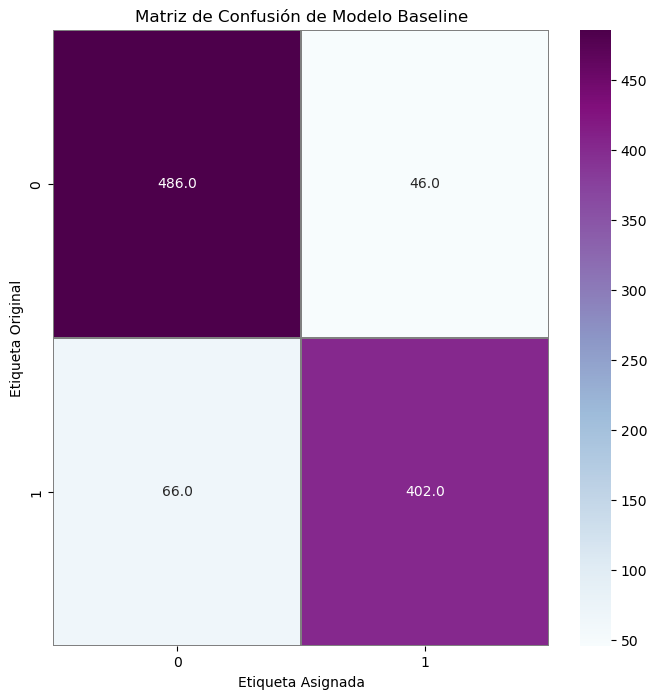

Sensitivity: 0.86
Specificity: 0.91
****************************************


In [11]:
# Parámetros:
# - El modelo a evaluar (keras.Model)
# - Nombre del modelo para el título de la Matriz de Confusión gráfica (String)
# - Etiquetas de las imágenes originales sobre las que se ha hecho el ataque (np.ndarray (,2))
# - Ataque adversarial a analizar (np.ndarray(,50.50,3))
# - Número de ataques adversariales a predecir (Int)

benchmarking.analizar_precision_perturbacion(modelo_base, "Baseline", 
                                test_labels, 
                                test_data, 
                                1000)

* Métricas de evaluación para la subred detectora (decibilidad adversarial)

In [26]:
benchmarking.analizar_precision_perturbacion(modelo_detector, "Detector", 
                                test_labels, 
                                data_adv_fgsm_03, 
                                100, True)

Decidibilidad Adversarial: 99.980000


* Robustez empírica

In [8]:
# Parámetros: Modelo, Imágenes a atacar, Tipo de ataque ('fgsm' o 'hsj'), Número de imágenes

benchmarking.empirical_robustness(modelo_pgd, test_data, 'hsj', 50)

HopSkipJump: 100%|█████████████████████████████████████████████████████████████████████| 50/50 [05:40<00:00,  6.81s/it]

0.008623716852322473


0.008623716852322473